In [1]:
import pickle
import matplotlib.pyplot as plt

log = pickle.load(open(r"D:\Project Advanced CV\experiments\brats3d_vnet_sup\logs\val_log.pkl", "rb"))
from pprint import pprint
pprint(log)

[{'ce_loss': 0.6299222707748413,
  'dice_et': 0.5320515334749856,
  'dice_loss': 0.9368474331769077,
  'dice_struct': 0.5037005275253575,
  'dice_tc': 0.5354257032783194,
  'dice_wt': 0.4436243458227678,
  'epoch': 1,
  'loss': 1.5667696996168656,
  'mean_dice_fg': 0.32174966137496414},
 {'ce_loss': 0.23486171527342362,
  'dice_et': 0.6106103296460273,
  'dice_loss': 0.8647095983678644,
  'dice_struct': 0.6822532245658178,
  'dice_tc': 0.6628334039314226,
  'dice_wt': 0.7733159401200035,
  'epoch': 2,
  'loss': 1.0995713103901257,
  'mean_dice_fg': 0.5007985150667302},
 {'ce_loss': 0.11336453082886609,
  'dice_et': 0.6952566391604293,
  'dice_loss': 0.7720163973894987,
  'dice_struct': 0.6867488870566397,
  'dice_tc': 0.6631796295430314,
  'dice_wt': 0.7018103924664584,
  'epoch': 3,
  'loss': 0.885380931334062,
  'mean_dice_fg': 0.4757095186449023},
 {'ce_loss': 0.06803423247554086,
  'dice_et': 0.6745973124847885,
  'dice_loss': 0.6255533164197749,
  'dice_struct': 0.7233858014062403

In [20]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

# Đường dẫn tới file log
train_log_path = "../experiments/brats3d_vnet_multienc_sup/logs_dice/train_log.pkl"
val_log_path   = "../experiments/brats3d_vnet_multienc_sup/logs_dice/val_log.pkl"

# Load list[dict] từ pickle
with open(train_log_path, "rb") as f:
    train_logs = pickle.load(f)

with open(val_log_path, "rb") as f:
    val_logs = pickle.load(f)

# Chuyển sang DataFrame cho tiện xử lý
train_df = pd.DataFrame(train_logs)
val_df   = pd.DataFrame(val_logs)

train_df.head(), val_df.head()


(       loss   ce_loss  dice_loss   dice_wt   dice_tc   dice_et  epoch
 0  0.884065  1.571040   0.884065  0.084367  0.023540  0.103902      1
 1  0.800354  1.572278   0.800354  0.086304  0.028776  0.313904      2
 2  0.702523  1.853951   0.702523  0.084938  0.028711  0.494973      3
 3  0.669445  2.009613   0.669445  0.083992  0.029406  0.530038      4
 4  0.656120  2.070305   0.656120  0.084199  0.029365  0.548586      5,
        loss   ce_loss  dice_loss  mean_dice_fg   dice_wt   dice_tc   dice_et  \
 0  2.294717  1.478575   0.816143      0.340617  0.072241  0.022327  0.429152   
 1  2.264971  1.553537   0.711434      0.384127  0.069918  0.022604  0.564512   
 2  2.462258  1.850655   0.611603      0.403431  0.068090  0.026787  0.586214   
 3  2.547049  1.973076   0.573973      0.432159  0.069941  0.027697  0.632450   
 4  2.590574  2.026516   0.564058      0.440643  0.067764  0.027351  0.646587   
 
    dice_struct  epoch  
 0     0.174573      1  
 1     0.219011      2  
 2     0.2

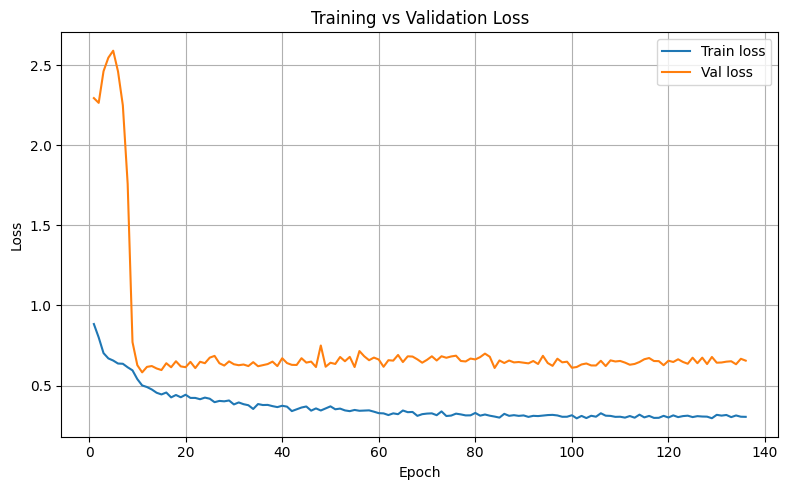

In [21]:
plt.figure(figsize=(8, 5))

plt.plot(train_df["epoch"], train_df["loss"], label="Train loss")
plt.plot(val_df["epoch"],   val_df["loss"],   label="Val loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


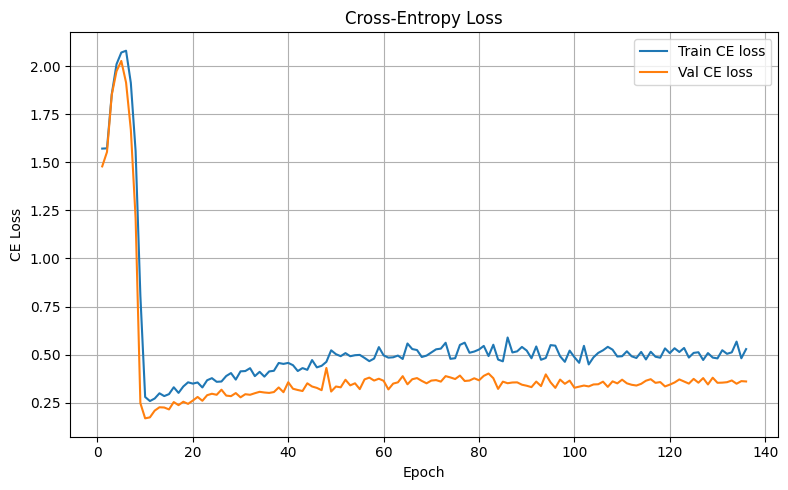

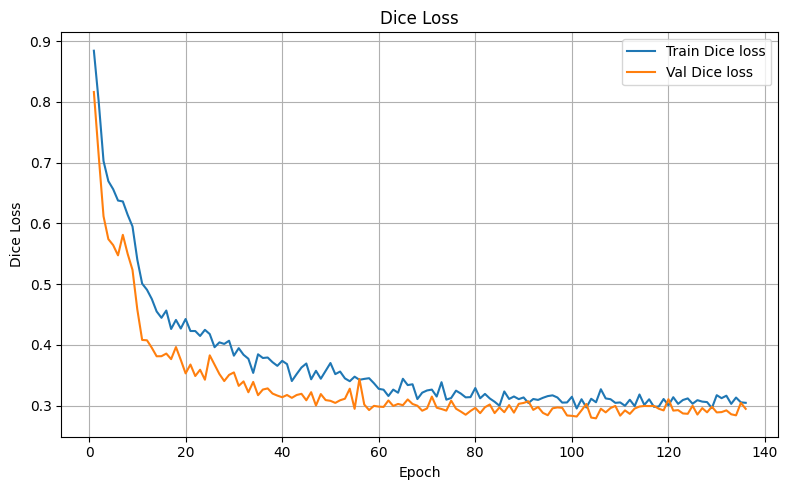

In [22]:
plt.figure(figsize=(8, 5))

plt.plot(train_df["epoch"], train_df["ce_loss"], label="Train CE loss")
plt.plot(val_df["epoch"],   val_df["ce_loss"],   label="Val CE loss")

plt.xlabel("Epoch")
plt.ylabel("CE Loss")
plt.title("Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))

plt.plot(train_df["epoch"], train_df["dice_loss"], label="Train Dice loss")
plt.plot(val_df["epoch"],   val_df["dice_loss"],   label="Val Dice loss")

plt.xlabel("Epoch")
plt.ylabel("Dice Loss")
plt.title("Dice Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


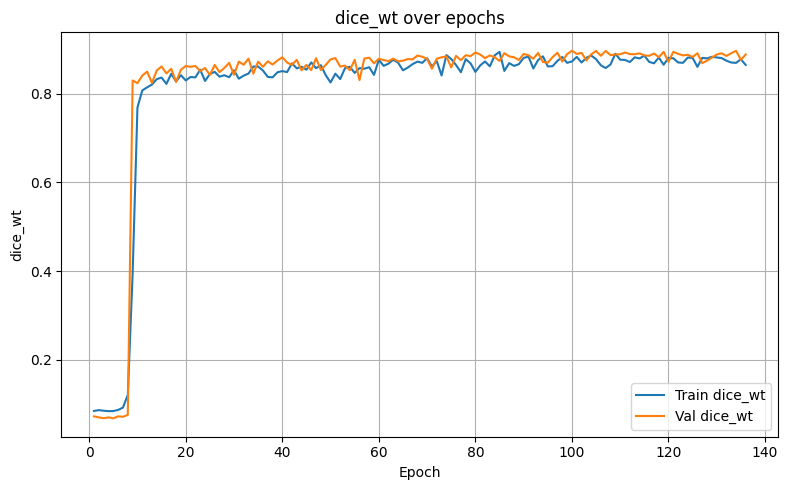

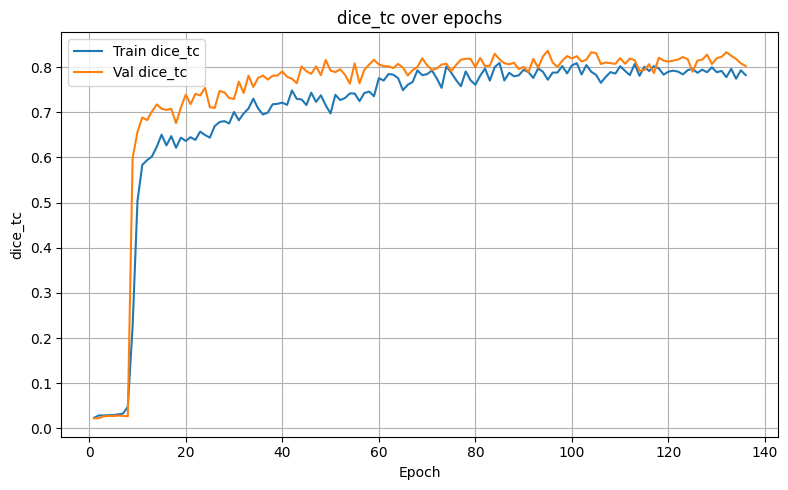

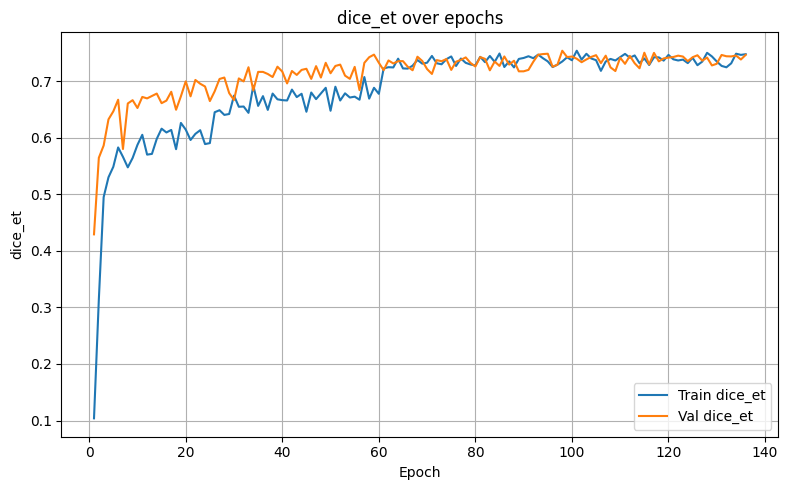

In [23]:
metrics = ["dice_wt", "dice_tc", "dice_et"]

for m in metrics:
    plt.figure(figsize=(8, 5))
    plt.plot(train_df["epoch"], train_df[m], label=f"Train {m}")
    plt.plot(val_df["epoch"],   val_df[m],   label=f"Val {m}")
    
    plt.xlabel("Epoch")
    plt.ylabel(m)
    plt.title(f"{m} over epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


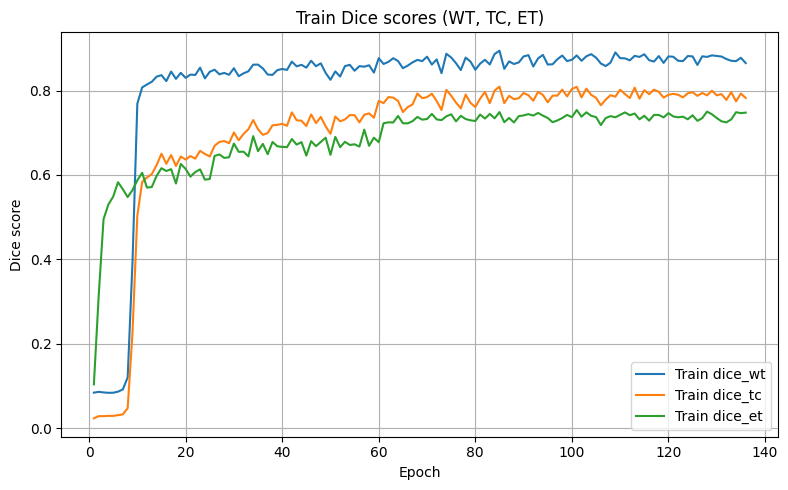

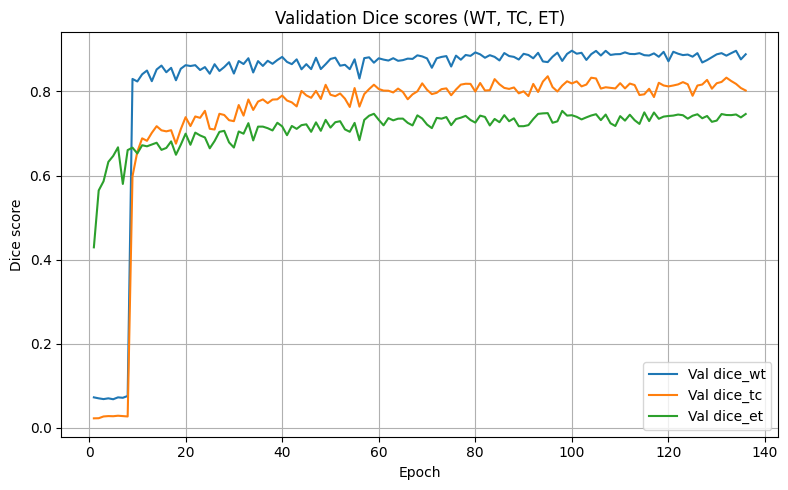

In [24]:
plt.figure(figsize=(8, 5))

plt.plot(train_df["epoch"], train_df["dice_wt"], label="Train dice_wt")
plt.plot(train_df["epoch"], train_df["dice_tc"], label="Train dice_tc")
plt.plot(train_df["epoch"], train_df["dice_et"], label="Train dice_et")

plt.xlabel("Epoch")
plt.ylabel("Dice score")
plt.title("Train Dice scores (WT, TC, ET)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))

plt.plot(val_df["epoch"], val_df["dice_wt"], label="Val dice_wt")
plt.plot(val_df["epoch"], val_df["dice_tc"], label="Val dice_tc")
plt.plot(val_df["epoch"], val_df["dice_et"], label="Val dice_et")

plt.xlabel("Epoch")
plt.ylabel("Dice score")
plt.title("Validation Dice scores (WT, TC, ET)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
